# Банки — Анализ оттока клиентов
# Задача**:**

Проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.

# Описание датасета

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности 
/ `equity`  — количество баллов собственности
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` / `last_activity` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Подготовка и переработка данных

In [1]:
!pip install phik

     |████████████████████████████████| 679 kB 1.9 MB/s eta 0:00:01


In [2]:
# Загрузим нужные библетеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import math
import phik
from phik.report import plot_correlation_matrix
from phik import report
import warnings
warnings.filterwarnings('ignore')

In [3]:
# загрузим  датасет
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
df = pd.read_csv(path)
    
display(df)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


In [4]:
# выведем информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [5]:
# выведем информацию по числовым значениям
df.describe().round(2)

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00,10000.00,9974.00,10000.00,7.705000e+03,10000.00,10000.00,10000.00,10000.00,10000.00
mean,171814.71,848.70,42.73,2.63,8.277943e+05,1.87,0.68,0.52,147866.89,0.18
std,33708.24,65.45,12.18,1.98,1.980614e+06,0.79,0.47,0.50,139388.51,0.39
min,94561.00,642.00,18.00,0.00,0.000000e+00,0.00,0.00,0.00,2546.30,0.00
25%,142810.25,802.00,33.00,0.00,2.955542e+05,1.00,0.00,0.00,75251.90,0.00
50%,172728.00,853.00,40.00,3.00,5.242722e+05,2.00,1.00,1.00,119658.10,0.00
75%,201261.75,900.00,51.00,4.00,9.807058e+05,2.00,1.00,1.00,174500.54,0.00
max,229145.00,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,1.00


In [6]:
# выведем количество пропусков
df.isna().sum()

USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

In [7]:
# Приведем данные к нижнему регистру
df.columns = df.columns.str.lower()
df = df.rename(columns = {'userid':'user_id'})
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [8]:
# Проверим есть ли явные дубликаты
df.duplicated().sum()

0

In [9]:
# Исладуем пропуски в балансе
df.query('balance.isnull()')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.0,Ростов,М,38.0,0,NaN,1,0,0,171763.69,0
9984,125941,729.0,Ярославль,Ж,42.0,0,NaN,1,1,1,687538.70,0
9993,219924,884.0,Рыбинск,Ж,36.0,0,NaN,1,1,1,169844.88,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0


In [10]:
df.groupby('churn')['balance'].apply(lambda x: x.isnull().sum())

churn
0    2282
1      13
Name: balance, dtype: int64

In [11]:
df.groupby('products')['balance'].apply(lambda x: x.isnull().sum())

products
0       1
1    1950
2     315
3      29
4       0
5       0
Name: balance, dtype: int64

<div class="alert alert-warning"><b>Комментарий ревьюера</b>&nbsp;🔧<br>
Посмотри, пожалуйста, не <tt>sum</tt>, а <tt>mean</tt> — иначе мы видим только сколько пропусков, а не видим соотношения пропуски/без пропусков
</div>

In [12]:
df.groupby('products')['balance'].apply(lambda x: x.isnull().mean())

products
0    1.000000
1    0.583658
2    0.061451
3    0.027911
4    0.000000
5    0.000000
Name: balance, dtype: float64

Подавляющее большинство клиентов с пропускми в балансе являются действющими клиентами имеющими 1-3 продукта. Для клиентов, имеющих единственный продукт, которым может является кредитная карта, нулевой остаток может считаться допустимым явлением, однако однозначный ответ на этот счет дать невозможно(В святая святых нас не посветят). Таким образом, однозначного ответа о причинах пропусков в балансе дать невозможно. Это может быть как наличие фактического нулевого остатка на счете, так и наличие технических ошибок при выгрузке данных. 

Варианты работы с пропусками:

1.Удаление данных (приведет к потери более 35 % что критично)
2.Вставить заглушку -1 или 0 , но тогда данные по баланссу сильно сместяться, а так как большинсво их действующие клиенты, а задача найти высооточных клиентов, то думаю это будет сравнимо с удалением данных.
3.Оставить все как есть. Считаю самым верным вариантом.

In [13]:
df.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


Есть одна женщина из Рыбинска которая имеет 0 продуктов. Считаю анамалией - можно удалить, но это всего 1 десятитысячная. Думаю на результаты не повлияет.

In [14]:
#Гендерное различие лучше будет анализировать в цифровом виде. Присвоим полу биномальные значения и изменим тип данных
df['gender'] = df['gender'].replace('Ж','0').replace('М','1').astype('int')
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,0,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,0,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,0,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,0,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,1,34.0,5,174.00,1,1,0,67353.16,1


In [15]:
#Закодируем города в столбце city
df_new = pd.get_dummies(df, columns=['city'], prefix='city_')
df_new.head()

,user_id,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city__Ростов,city__Рыбинск,city__Ярославль
0,183012,850.0,0,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0
1,146556,861.0,0,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0
2,120722,892.0,0,30.0,0,NaN,1,1,1,107683.34,0,0,1,0
3,225363,866.0,0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1
4,157978,730.0,1,34.0,5,174.00,1,1,0,67353.16,1,0,0,1


# Вывод по загрузке данных
10000 строк

11 столбцов

Пропущенные значения (около 36%) есть в столбце Balance и возрасте Age  меньше 1%.

Дубликаты не обнаружены.

Типы данных корректные, соответсвуют значениям столбцов.

##  Ислледовательский анализ

Посмотрим графически на распрределение по всем признакам.

In [16]:
def plot_hist(df_new):
    sns.set(style="darkgrid", font_scale=1.1)
    for column in df.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=df, x=column)
        plt.show()

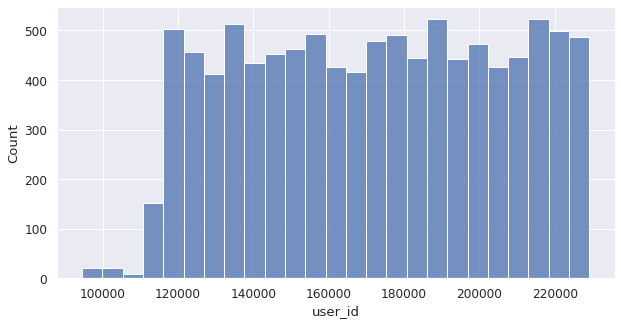

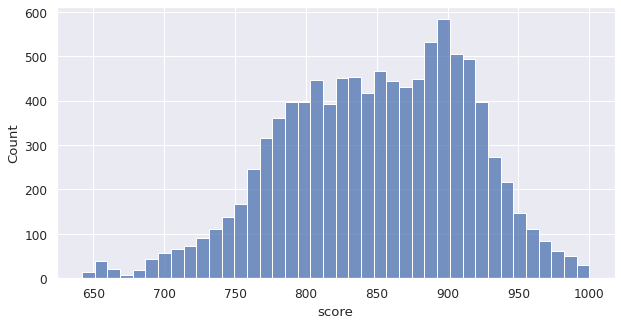

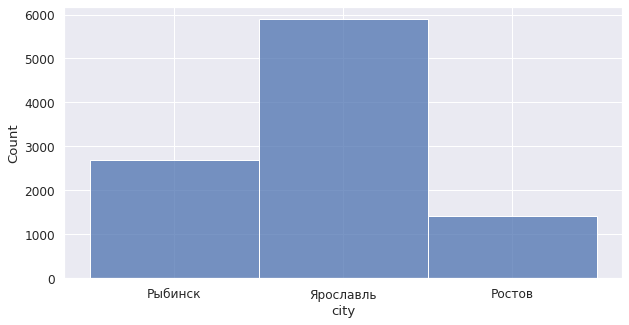

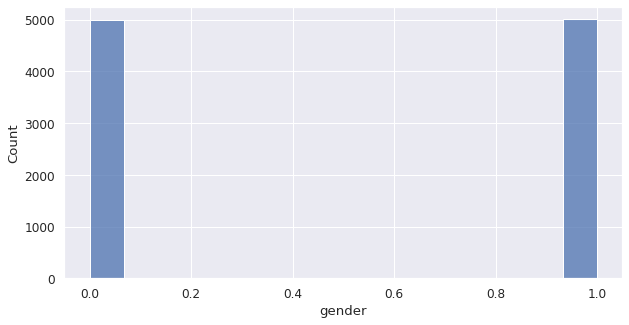

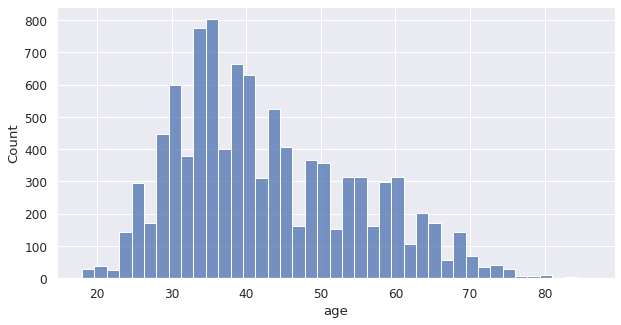

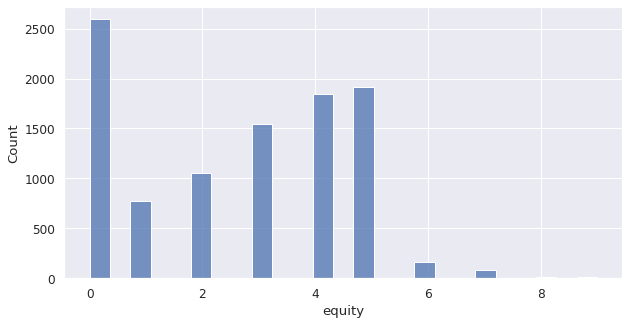

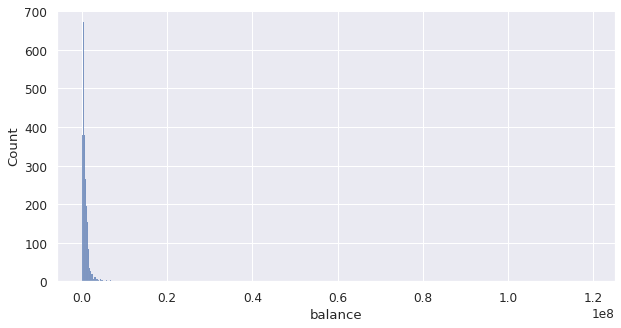

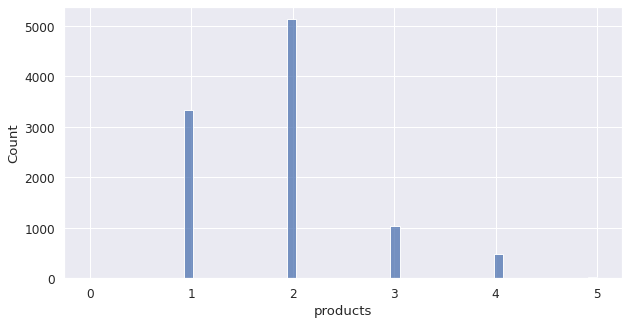

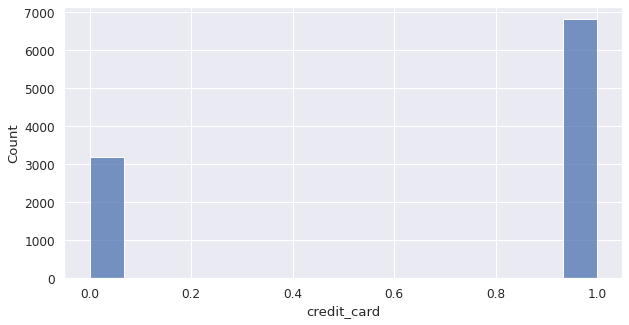

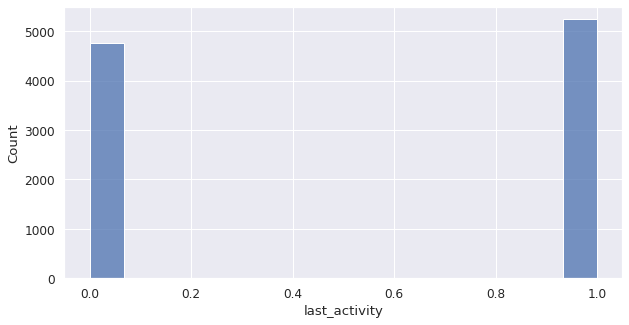

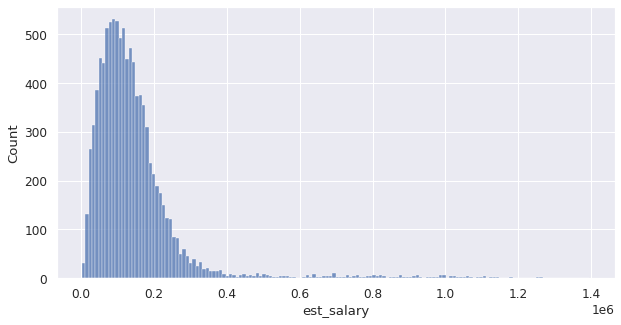

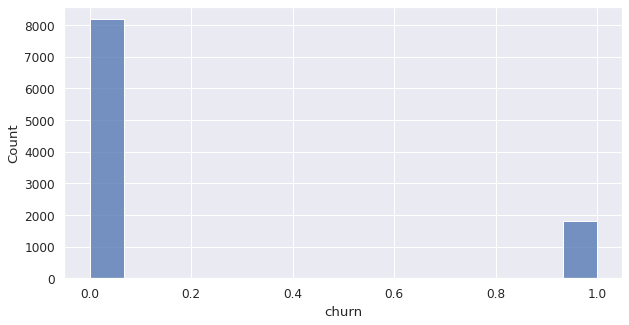

In [17]:
plot_hist(df_new)

Выявление портрета клиента, склонных уходить из банка:
Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;

In [19]:
round(df_new.groupby('churn').agg('mean').T,2)

churn,0,1
user_id,172004.36,170962.35
score,845.43,863.40
gender,0.47,0.65
age,43.02,41.45
equity,2.37,3.76
balance,733982.59,1133993.27
products,1.76,2.38
credit_card,0.71,0.55
last_activity,0.48,0.70
est_salary,147783.20,148243.01


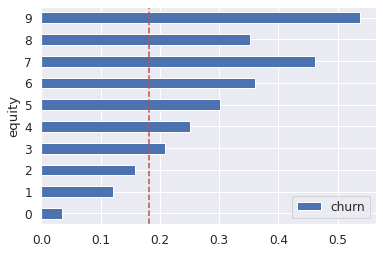

In [20]:
df_new.groupby('equity').agg({'churn':'mean'}).plot(kind='barh')
plt.axvline(df_new.churn.mean(),color='r',ls='dashed');

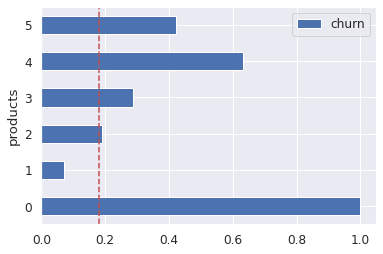

In [21]:
df_new.groupby('products').agg({'churn':'mean'}).plot(kind='barh')
plt.axvline(df_new.churn.mean(),color='r',ls='dashed');

# выведем график распределения количества клиентов по балансу
plt.figure(figsize=(10,5))
sns.countplot(x='balance', data=df_new, hue='churn')
plt.title('Распределение клиентов по городам')
plt.show()

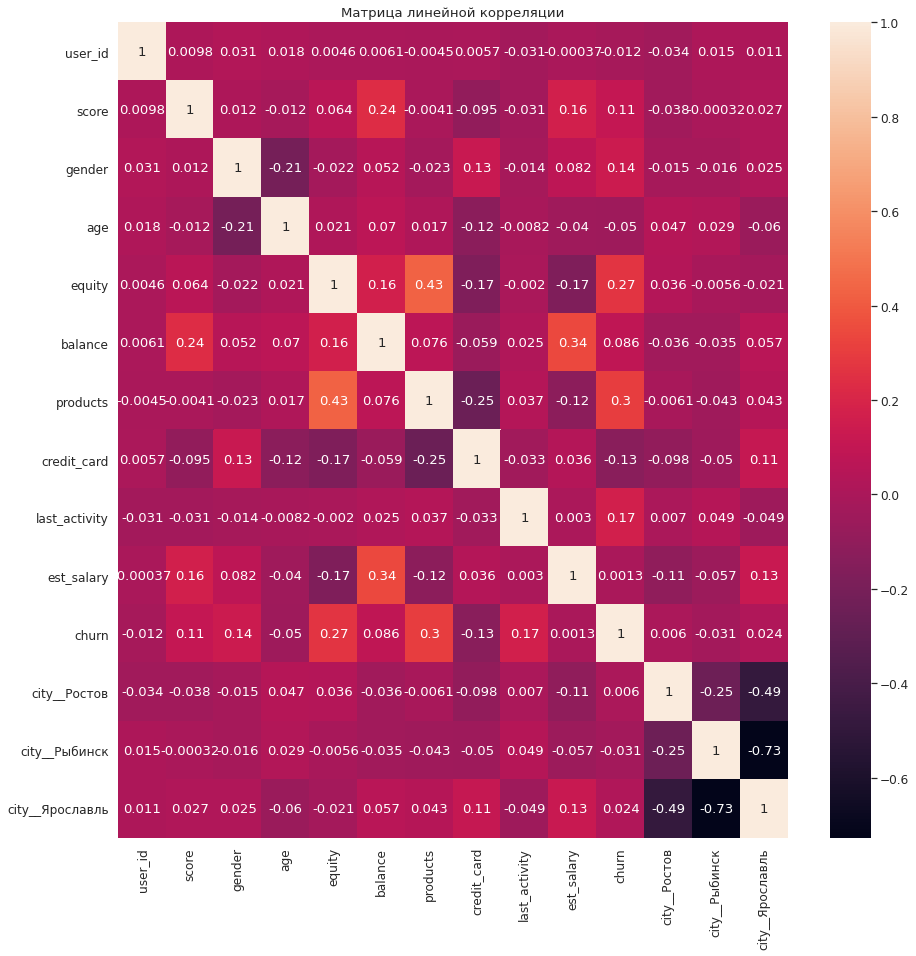

In [22]:
plt.figure(figsize = (15,15))
sns.heatmap(df_new.corr(), annot=True)
plt.title('Матрица линейной корреляции')
plt.show()

In [23]:
phik_matrix = df_new.phik_matrix()
phik_matrix.head()

interval columns not set, guessing: ['user_id', 'score', 'gender', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'city__Ростов', 'city__Рыбинск', 'city__Ярославль']


,user_id,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city__Ростов,city__Рыбинск,city__Ярославль
user_id,1.000000,0.064716,0.059816,0.000000,0.073472,0.034065,0.074676,0.035569,0.065859,0.000000,0.139665,0.044393,0.000000,0.000000
score,0.064716,1.000000,0.071359,0.036178,0.527991,0.170900,0.308251,0.208895,0.054473,0.395960,0.228179,0.087290,0.027389,0.084186
gender,0.059816,0.071359,1.000000,0.286026,0.064554,0.045424,0.122547,0.196238,0.014156,0.144714,0.218799,0.017018,0.019485,0.036020
age,0.000000,0.036178,0.286026,1.000000,0.043708,0.024989,0.133418,0.157196,0.089172,0.358167,0.182538,0.068652,0.059167,0.097571
equity,0.073472,0.527991,0.064554,0.043708,1.000000,0.000000,0.442391,0.221940,0.051091,0.286452,0.352726,0.065462,0.000000,0.054950


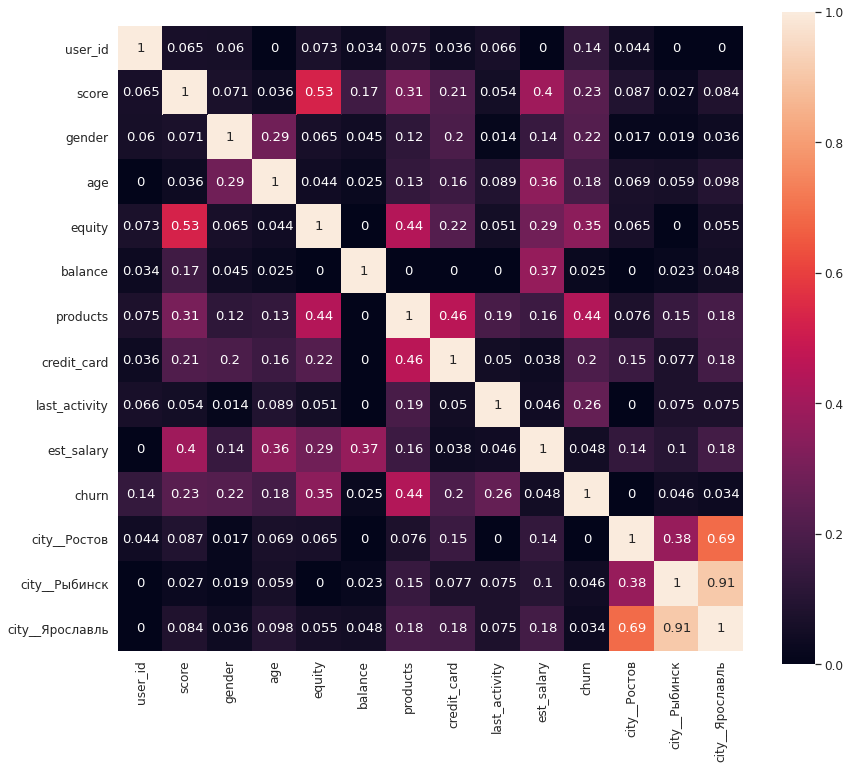

In [24]:
# нарисуем тепловую карту с подписями для матрицы корреляций коэффициента Phik
plt.figure(figsize=(14, 12))
sns.heatmap(phik_matrix, annot=True, square=True)
plt.show()

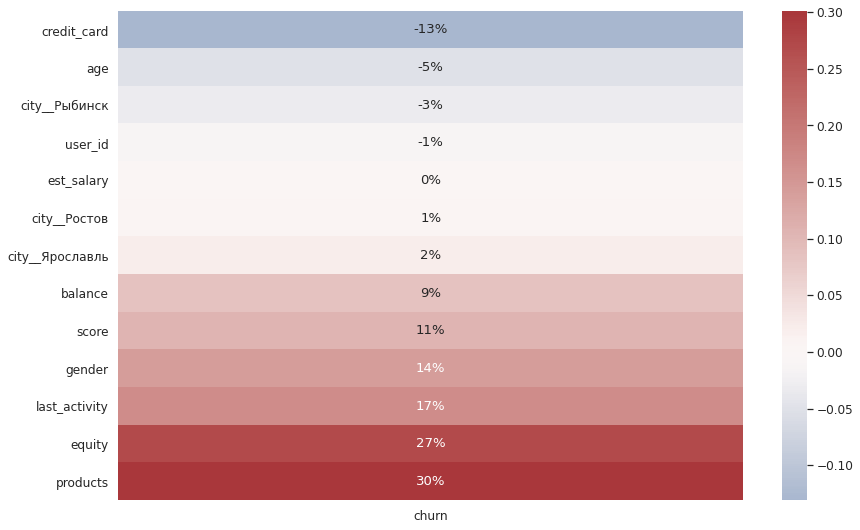

In [25]:
plt.figure(figsize=(14,9))
sns.heatmap(df_new.corr().loc[:,['churn']].drop('churn').sort_values('churn'),cmap='vlag', annot=True, fmt = '.0%', center = 0);

Выводы:

Линейной зависимости между оттоком и признаками не наблюдается

Обнаружена нелинейная зависимость между оттоком пользователей и продуктами использованным пользователем.

Обнаружена нелинейная зависимость между оттоком пользователей и количество баллов собственности.

Обнаружена нелинейная зависимость между оттоком пользователей и последней активностью.

Обнаружена нелинейная зависимость между оттоком пользователей и полом.

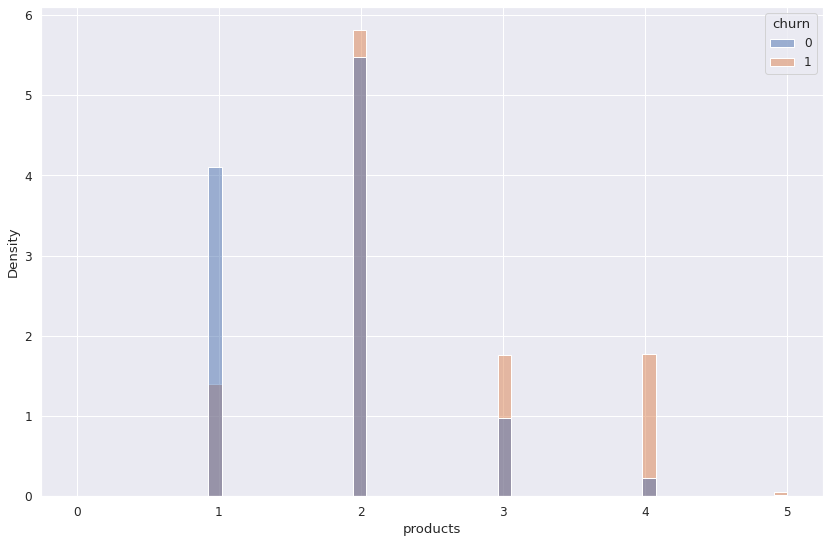

In [26]:
plt.figure(figsize=(14,9))
sns.histplot(data=df_new, x = 'products', hue = 'churn',stat = 'density', common_norm  = False);

На графике видно, что самые высокооточные клиенты которые используют 2-4 продуктов

In [27]:
for x in df_new['products'].unique():
    display(f'Клиенты, пользующиеся {x} продуктами', df[(df.products == x)]\
            .drop(['user_id', 'products'], axis=1).groupby('churn').mean())

'Клиенты, пользующиеся 2 продуктами'

,score,gender,age,equity,balance,credit_card,last_activity,est_salary
churn,,,,,,,,
0,839.926694,0.436460,43.227723,3.009887,7.296138e+05,0.664336,0.461538,126885.150113
1,864.206333,0.649642,40.826176,3.749745,1.140471e+06,0.460674,0.747702,145264.380582


'Клиенты, пользующиеся 3 продуктами'

,score,gender,age,equity,balance,credit_card,last_activity,est_salary
churn,,,,,,,,
0,832.218329,0.371968,46.337382,3.366577,9.386734e+05,0.369272,0.346361,124035.063841
1,850.023569,0.575758,44.161616,3.898990,1.128787e+06,0.323232,0.592593,140196.894545


'Клиенты, пользующиеся 1 продуктами'

,score,gender,age,equity,balance,credit_card,last_activity,est_salary
churn,,,,,,,,
0,854.609466,0.526722,42.249028,1.189311,601133.031151,0.860914,0.518352,183899.794688
1,850.182979,0.727660,41.502128,3.114894,660515.440485,0.902128,0.659574,138849.512298


'Клиенты, пользующиеся 4 продуктами'

,score,gender,age,equity,balance,credit_card,last_activity,est_salary
churn,,,,,,,,
0,869.505747,0.545977,38.114943,4.126437,9.120333e+05,0.500000,0.948276,105456.282241
1,883.350000,0.666667,40.750000,4.166667,1.474177e+06,0.786667,0.696667,173921.901833


'Клиенты, пользующиеся 5 продуктами'

,score,gender,age,equity,balance,credit_card,last_activity,est_salary
churn,,,,,,,,
0,837.363636,0.454545,36.000,3.090909,1.742656e+05,1.0,1.00,99789.689091
1,889.375000,0.625000,37.125,4.500000,1.211478e+06,1.0,0.75,139837.798750


'Клиенты, пользующиеся 0 продуктами'

,score,gender,age,equity,balance,credit_card,last_activity,est_salary
churn,,,,,,,,
1,962.0,0,79.0,3,NaN,0,0,25063.96


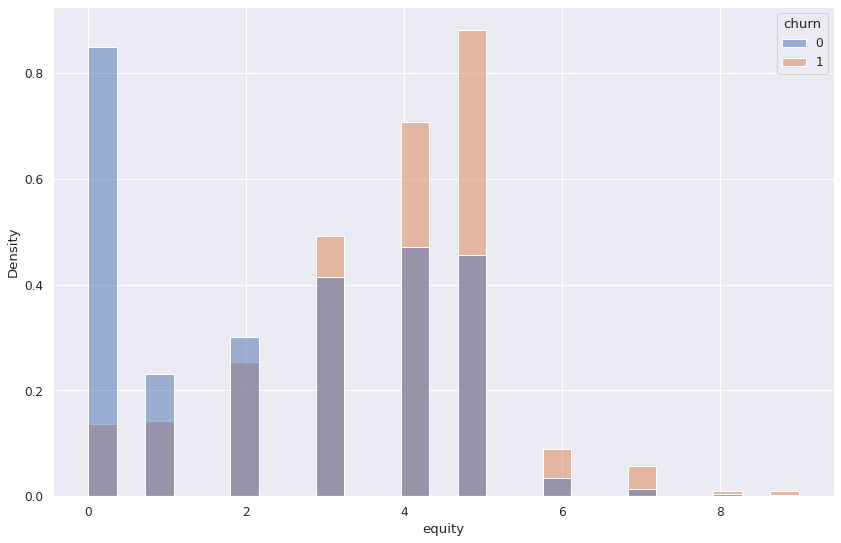

In [28]:
plt.figure(figsize=(14,9))
sns.histplot(data=df_new, x = 'equity', hue = 'churn' , stat = 'density' ,common_norm  = False);

На графике видно, что самые высокооточные клиенты с балами(объектами) в собственности от 3 -8.

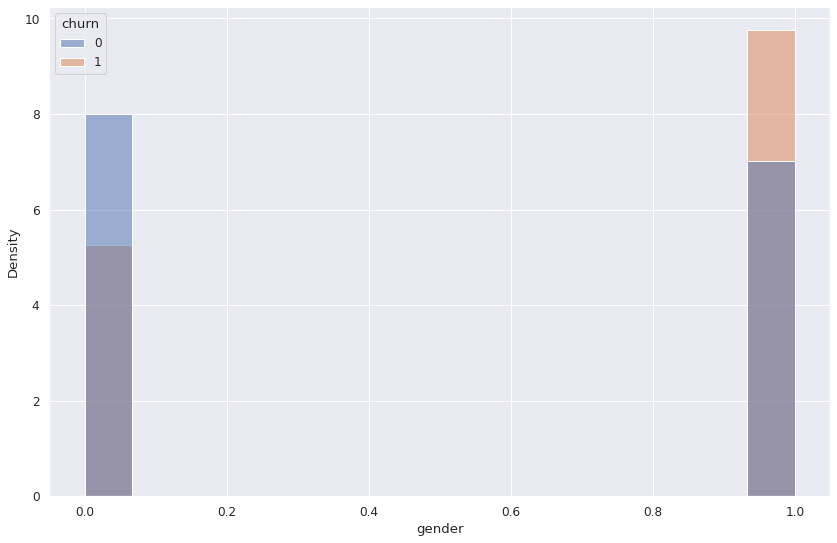

In [29]:
plt.figure(figsize=(14,9))
sns.histplot(data=df_new, x = 'gender', hue = 'churn' , stat = 'density' ,common_norm  = False);

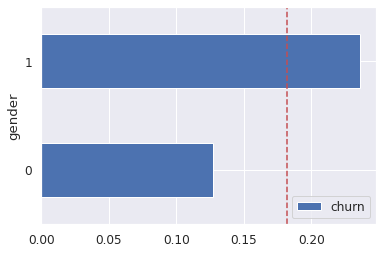

In [30]:
df_new.groupby('gender').agg({'churn':'mean'}).sort_values("churn").plot(kind='barh')
plt.axvline(df_new.churn.mean(),color='r',ls='dashed');

Высокооточнемы клиентами оказались мужчины.

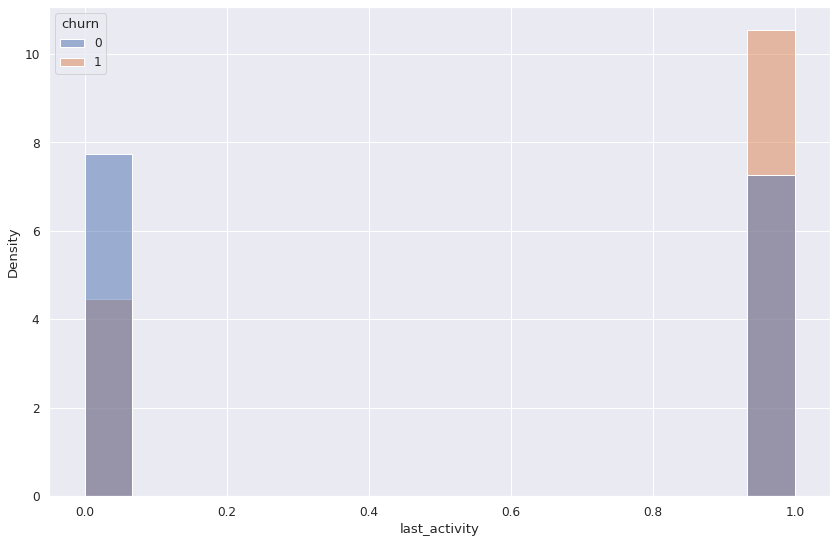

In [31]:
plt.figure(figsize=(14,9))
sns.histplot(data=df_new, x = 'last_activity', hue = 'churn' , stat = 'density' ,common_norm  = False);

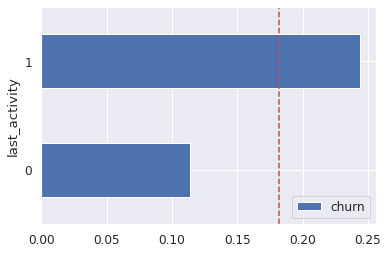

In [32]:
df_new.groupby('last_activity').agg({'churn':'mean'}).sort_values("churn").plot(kind='barh')
plt.axvline(df_new.churn.mean(),color='r',ls='dashed');

По графику видно что высокооточным клиентом является активный клиент.

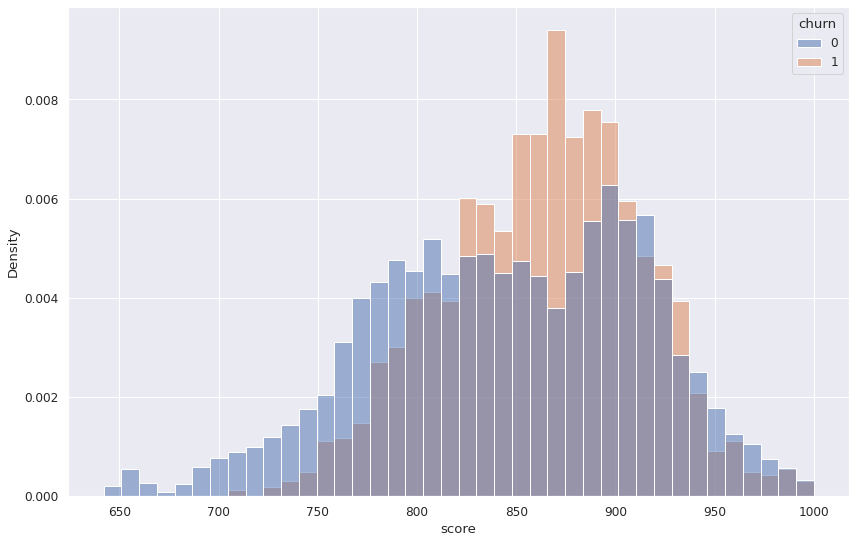

In [33]:
plt.figure(figsize=(14,9))
sns.histplot(data=df_new, x = 'score', hue = 'churn' , stat = 'density' ,common_norm  = False);

По графику видно что высокооточным клиентом c высоким кредитным балом от 820-920

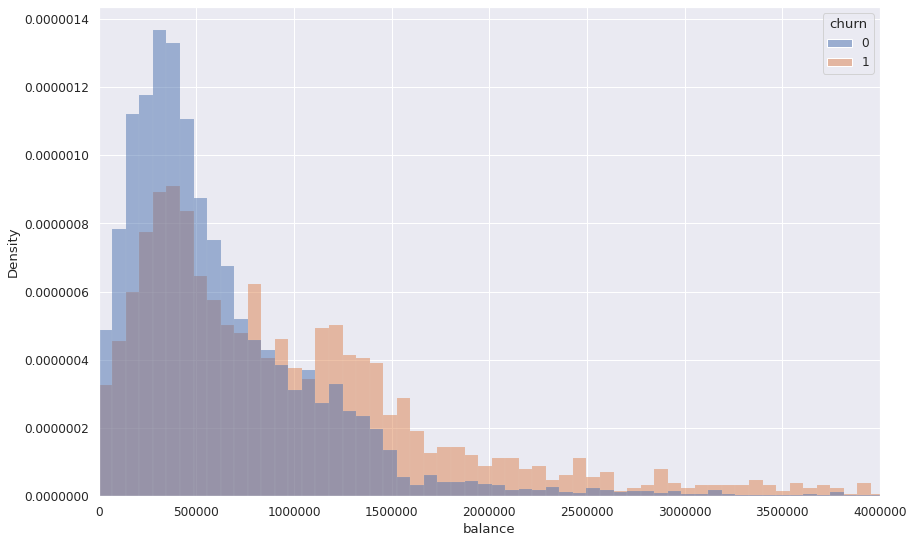

In [34]:
plt.figure(figsize=(14,9))
plt.ticklabel_format(useOffset = False)
sns.histplot(data=df_new, x = 'balance', hue = 'churn' , stat = 'density',common_norm  = False)
plt.ticklabel_format(style='plain')
plt.xlim([0, 4000000])

plt.show()

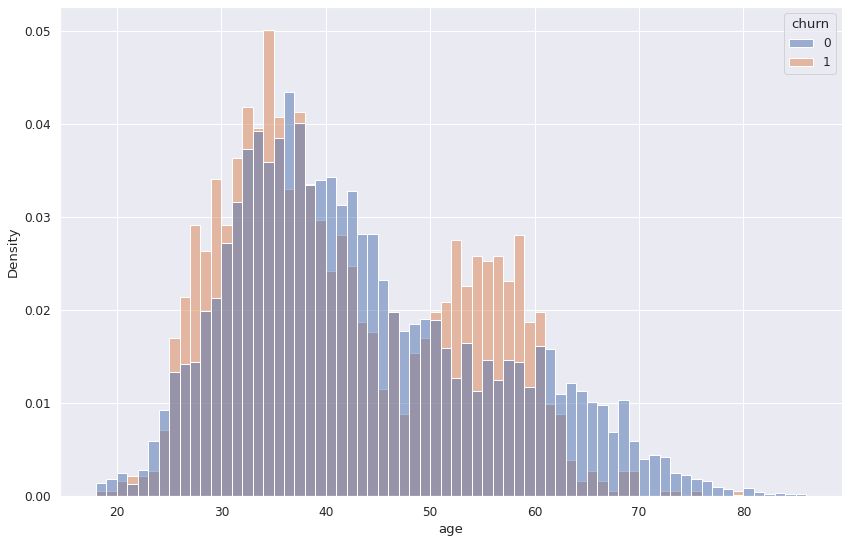

In [35]:
plt.figure(figsize=(14,9))
sns.histplot(data=df_new, x = 'age', hue = 'churn' , stat = 'density' ,common_norm  = False, binwidth = 1);

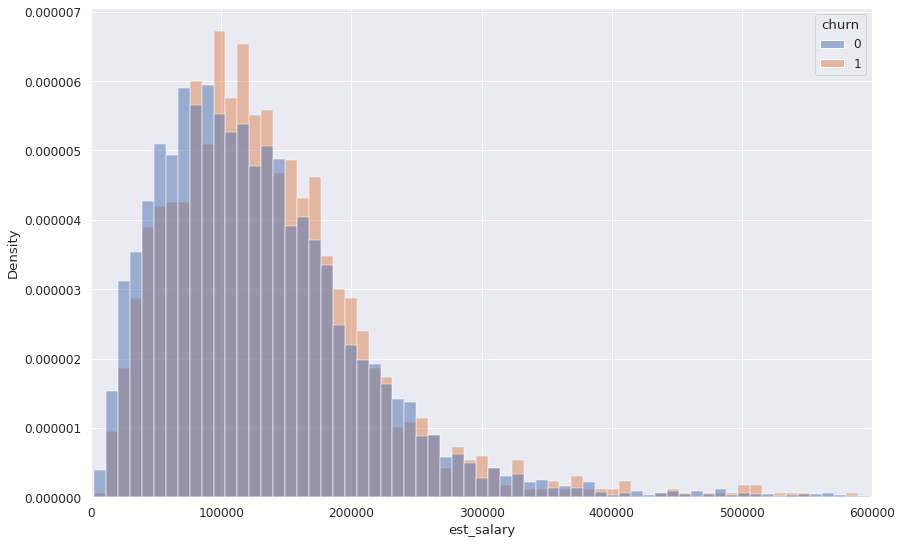

In [36]:
plt.figure(figsize=(14,9))
sns.histplot(data=df_new, x = 'est_salary', hue = 'churn' , stat = 'density' ,common_norm  = False)
plt.ticklabel_format(style='plain')
plt.xlim([0, 600000])
plt.show()

Портрет клиента склонного к оттоку:

Чаще в отток попадают мужчины.

Клиент чаще всего активен.

Клиент начал использовать больше чем 2 продукта.

Клиент имеет неслько балов (объектов) в собственности 3-8.

Имеет высоким уровень кредитного скоринга 820-920.

Баланс от 750 000 тыс рублей 

Заработная плата 100-200 тыс. руб.

Возраст от 25-35 лет и от 50-60 лет.

Выполним сегментацию:

In [37]:

df_new.query('gender ==1 & products > 2 & last_activity == 1').agg({'churn':['mean','count']})


,churn
mean,0.545894
count,414.000000


In [38]:
df_new.query('gender == 1 & balance > 750000 & last_activity == 1').agg({'churn':['mean','count']})

,churn
mean,0.597458
count,708.000000


In [39]:
df_new.query('gender == 1 & equity > 4 & last_activity == 1').agg({'churn':['mean','count']})

,churn
mean,0.543624
count,596.000000


In [40]:
df_new.query('100000< est_salary > 200000 & balance > 750000 & last_activity == 1').agg({'churn':['mean','count']})

,churn
mean,0.607843
count,306.000000


In [41]:
df_new.query('gender == 1 & balance > 750000 & credit_card == 0').agg({'churn':['mean','count']})

,churn
mean,0.559649
count,570.000000


Выводы: 
* Сегмент 1: Активные клиенты мужчины использующие более 2х продуктов  (54% оттока, 414 человек)
* Сегмент 2: Активные клиенты мужчины с балансом более 750000 (60% оттока, 708 человек)
* Сегмент 3: Активные клиенты мужчины с количеством балов (объектов) в собственности больше 4  (54% оттока, 596 человек) 
* Сегмент 4: Активные клиенты с зарплатой 100-200 тыс и балансом более 750000 (60%, 306 человек)
* Сегмент 5: Мужчины с балансом более 750000 без кредитной карты (56% оттока, 570 человек)

## Сформулируем и проверим статистические гипотезы:

Сформируем нулевую и альтернативную гипотезы:

* Н0 Нулевая гипотеза - доходы между теми, кто ушел в отток и теми, кто остался равны
* Н1 Альтернативная гипотеза - доходы между теми, кто ушел в отток и теми, кто остался не равны

Будем проверять гипотезы используя t-критерий Стьюдента.

Генеральных совокупностей в нашей задаче две: первая - это все пользователи, которые ушли, вторая - это пользователи, которые остались. Т.е. мы должны проверить равенство средних двух генеральных совокупностей.

In [42]:
df_churn_0 = df_new[df_new['churn'] == 0] # сделаем фильтр тех кто ещё остался
df_churn_1 = df_new[df_new['churn'] == 1] # и тех кто уже ушёл

In [43]:
# посчитаем дисперсию и средние значения зарплат клиентов в оттоке и оставшихся
var_churn_1 = np.array(df_churn_1['est_salary'])
var_churn_0 = np.array(df_churn_0['est_salary'])

print('Дисперсия зарплат оставшихся клиентов:', np.var(var_churn_0))
print('Дисперсия зарплат ушедших клиетов:', np.var(var_churn_1))
print()
print('Средняя зарплата оставшихся клиентов:', np.mean(var_churn_0))
print('Средняя зарплата ушедших клиетов:', np.mean(var_churn_1))

Дисперсия зарплат оставшихся клиентов: 20390026478.417816
Дисперсия зарплат ушедших клиетов: 15099675278.93616

Средняя зарплата оставшихся клиентов: 147783.20010757947
Средняя зарплата ушедших клиетов: 148243.01019780218


Так как данные по доходу у нас не имеют нормального распределение и дисперсии не равны, то мы будем проверять гипотезы используя t-критерий Стьюдента с указанием equal_var=False.

In [44]:
sample_1 = df_churn_0['est_salary'] # доход тех кто ушёл
sample_2 = df_churn_1['est_salary'] # и тех кто остался

alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

p-значение: 0.8987254468291451
Не получилось отвергнуть нулевую гипотезу.


Равенство 2 х средних генеральных совокупностей  практически равны, более точным будет тест Стьюдента.

In [45]:
sample_1 = df_churn_0['est_salary'] # доход тех кто ушёл
sample_2 = df_churn_1['est_salary'] # и тех кто остался
alpha = 0.05

results = st.mannwhitneyu(
    sample_1, 
    sample_2,
    True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.000243559272811695
Отвергаем нулевую гипотезу


Так как дисперсии не равны и есть количество выбросов  t  тест окажестся более мощным.

Проверим  статистическим тестом на нормальность или посчитаем методами kurt (эксцесс) и skew (асимметрия)

In [46]:
sample_1.kurt(axis = 0)

21.64120081001691

Положительный перекос указывает на то, что хвост находится на правой стороне распределения, которое распространяется в сторону более положительных значений.

In [47]:
sample_2.kurt(axis = 0)

24.509562128673803

Положительный перекос указывает на то, что хвост находится на правой стороне распределения, которое распространяется в сторону более положительных значений.

In [48]:
sample_1.skew(axis = 0)

4.068417082445628

Если данное распределение имеет эксцесс, превышающий 3, оно называется лептокуртическим, что означает, что оно имеет тенденцию производить больше выбросов, чем нормальное распределение.

In [49]:
sample_2.skew(axis = 0)

4.161546591517624

Если данное распределение имеет эксцесс, превышающий 3, оно называется лептокуртическим, что означает, что оно имеет тенденцию производить больше выбросов, чем нормальное распределение.

In [50]:
from scipy.stats import shapiro
shapiro(df_new['est_salary'])

ShapiroResult(statistic=0.6189883947372437, pvalue=0.0)

Поскольку в приведенном выше примере значение p равно 0,0, что меньше альфа (0,05), то мы отвергаем нулевую гипотезу, т. Е. У нас есть достаточные доказательства того, что выборка не исходит из нормального распределения.

In [51]:
shapiro(sample_1)

ShapiroResult(statistic=0.6149210929870605, pvalue=0.0)

Поскольку в приведенном выше значение pvalue равно 0,0, что меньше альфа (0,05), то мы отвергаем нулевую гипотезу, т. Е. У нас есть достаточные доказательства того, что выборка не исходит из нормального распределения.

In [52]:
shapiro(sample_2)

ShapiroResult(statistic=0.6442221999168396, pvalue=0.0)

Поскольку в приведенном выше значение pvalue равно 0,0, что меньше альфа (0,05), то мы отвергаем нулевую гипотезу, т. Е. У нас есть достаточные доказательства того, что выборка не исходит из нормального распределения.

Проверим так же при чистке данных

In [53]:
print(np.percentile(df_new['est_salary'],[95,99]))

[316885.3445 887903.8546]


In [54]:
g = df_new.query('churn == 0 & est_salary<317000')['est_salary']
g2 = df_new.query('churn == 1 & est_salary<317000')['est_salary']
print('Разница групп g и  g2 -{}'.format(len(g)/len(g2)))

Разница групп g и  g2 -4.46662830840046


In [55]:
results = st.ttest_ind(
    g, 
    g2,
    equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

p-значение: 0.00015541781173579163
Отвергаем нулевую гипотезу.


In [56]:
results = st.mannwhitneyu(
    g, 
    g2,
    True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0767205073797545e-05
Отвергаем нулевую гипотезу


Тест Стьюдента показал что нулевую гепотизу отвергаем(так же как и в первом случае- без очистки) . При очистки данных и если мы знаем что выбросы присутсвуют и их очищать, то лучше доверять тесту Манна Уйтни. Это можно заметить по значению p value

# Вывод

Нет оснований говорить о различии в доходе между пользователями, которые ушли и пользователями, которые остались

# Гипотеза № 2
Сформируем нулевую и альтернативную гипотезы:

* Н0 - статистически значимых различий количества используемых продуктов банка между клиентами, ушедшими в отток, и клиентами, которые продолжают пользоваться продуктами банка нет.

* Н1 - статистически значимые различия количества используемых продуктов банка между клиентами, ушедшими в отток, и клиентами, которые продолжают пользоваться продуктами банка есть.

In [57]:
# посчитаем дисперсию и средние значения зарплат клиентов в оттоке и оставшихся
var_churn_1 = np.array(df_churn_1['products'])
var_churn_0 = np.array(df_churn_0['products'])

print('Дисперсия продуктов оставшихся клиентов:', np.var(var_churn_0))
print('Дисперсия продуктов ушедших клиетов:', np.var(var_churn_1))
print()
print('Средняя продуктов оставшихся клиентов:', np.mean(var_churn_0))
print('Средняя продуктов ушедших клиетов:', np.mean(var_churn_1))

Дисперсия продуктов оставшихся клиентов: 0.5088361947860187
Дисперсия продуктов ушедших клиетов: 0.8521627822726723

Средняя продуктов оставшихся клиентов: 1.7575794621026894
Средняя продуктов ушедших клиетов: 2.375824175824176


In [58]:
sample_1 = df_churn_0['products'] # продукты тех кто ушёл
sample_2 = df_churn_1['products'] # продукты  тех кто остался

alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.941369148892939e-208
Отвергаем нулевую гипотезу


Проверим еще тестом Манна Утнии

In [59]:
sample_1 = df_churn_0['products'] # те кто ушёл
sample_2 = df_churn_1['products'] # и тех кто остался

alpha = 0.05

results = st.mannwhitneyu(
    sample_1, 
    sample_2,
    True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.741137692868694e-162
Отвергаем нулевую гипотезу


# Вывод : 
Есть основания считать значимые различия количества используемых продуктов банка между клиентами, ушедшими в отток, и клиентами, которые продолжают пользоваться продуктами банка есть.

## Общий вывод:

В результате работы  был проанализирован датасет на 10 тыс. клиентов банка из 3 городов. 
Есть пропуски по балансу, что не дает понимая общий картины из за чего возникли эти пропуски.
Явных дубликатов не обнаружено.


Признаки, которые располагают к оттоку клиентов:

Использование более двух продуктов в банке;
По гендерному признаку - Мужчины;
Клиент имеет высокий скоринговый бал 820-920;
Клиент имеет неслько балов (объектов) в собственности 3-8.


Статистический анализ и проверка гипотез:

Гипотеза о различии дохода между ушедшими и оставшимся клиентами была отвергнута.
Гипотеза о различии использования количества используемых продуктов банка между ушедшими и оставшимся клиентами подтвердилась.

In [60]:
### КОД РЕВЬЮЕРА

df.query('(820 < score < 920) and equity > 2').agg({"churn":"mean","user_id":"count"})

churn         0.314675
user_id    3305.000000
dtype: float64

In [64]:
### КОД РЕВЬЮЕРА 2
from functools import reduce
import itertools as it

# формируем список с сегментами
segments =[
    df_new.query('gender ==1 & products > 2 & last_activity == 1'),
    df_new.query('gender == 1 & balance > 750000 & last_activity == 1'),
    df_new.query('gender == 1 & equity > 4 & last_activity == 1'),
    df_new.query('100000< est_salary > 200000 & balance > 750000 & last_activity == 1'),
    df_new.query('gender == 1 & balance > 750000 & credit_card == 0'),
    df_new.query('(25 < age < 35) and products >2'),
    df_new.query('(credit_card == 0) and 100000< est_salary > 200000'),
    df_new.query('(25 < age < 35) and products >2')
]

# считаем общие показатели
seg_idx = [seg.index for seg in segments]
sex_churn_idx = [seg.query('churn==1').index for seg in segments]
in_selection = reduce(set().union,seg_idx)
in_selection_churn = reduce(set().union,sex_churn_idx)
in_churn = df.query('churn==1').index
not_in_selection = in_churn.difference(in_selection)

# делаем список эффективности комбинаций трёх сегментов
comb_3_churn_len = [len(reduce(set().union,[seg.query('churn==1').index for seg in seg_3])) 
                for seg_3 in it.combinations(segments,r=3)]
    
    
print('Отточных',len(in_churn),
      '\nПопало в сегментацию клиентов всего:\t',len(in_selection),
      '\nПопало в сегментацию отточных:\t\t',len(in_selection_churn),
      '\nНе попало в сегментацию отточных:\t',len(not_in_selection),
      f'\nПроцент успеха по всем:\t\t\t {len(in_selection_churn)/len(in_churn):.1%}',
      f'\nПроцент успеха по 3 лучшим:\t\t {max(comb_3_churn_len)/len(in_churn):.1%}',)

Отточных 1820 
Попало в сегментацию клиентов всего:	 1963 
Попало в сегментацию отточных:		 836 
Не попало в сегментацию отточных:	 984 
Процент успеха по всем:			 45.9% 
Процент успеха по 3 лучшим:		 36.1%


# Рекомендации
Исходя из проведенного исследования, мы можем дать следующие рекомендации:

Активные клиенты - мужчины которые начинают пользоваться 2-4 продуктами уходят из банка. Необходимо узнать причину что не устраивает клиентов при использовании более двух продуктов и исправить проблему.(54% оттока, 414 человек).

Необходимо выдать кредитные карты мужчинам с балансом более 750 000 тыс.руб не имееющие их (56% оттока, 570 человек).

Нужны новые фишки или возможности для активных пользователей банка в категории мужчин с зарплатой от 100-200 тыс рублей с балансом более 750000 руб.(акции, бонусы, кэшбеки за действия).(60% оттока, 306 человек).

Разработать стратегию по вкладам или инвестициям для мужчин в категории "активные пользователи" с балансом более 750 тыс. руб. (60% оттока, 708 человек). 

Педоставлять более выгодные условия по лизингу или кредиту в заем собствености для активных мужчин с количеством балов (объектов) больше 4 (54% оттока, 596 человек)

In [65]:
df_new.query('(820 < score < 920) and equity > 2').agg({"churn":"mean","user_id":"count"})

churn         0.314675
user_id    3305.000000
dtype: float64

In [66]:
df_new.query('(credit_card == 0) and 100000< est_salary > 200000').agg({"churn":"mean","user_id":"count"})

churn        0.304511
user_id    532.000000
dtype: float64

In [67]:
df_new.query('(25 < age < 35) and products >2').agg({"churn":"mean","user_id":"count"})

churn        0.45961
user_id    359.00000
dtype: float64

# Рекомендации доп:
Необходимо выдовать ипотеки людям с высоким скоринговым баломм от 820 - 920 и более 3 баллов(объектов) в собственности.(31% оттока, 3305 человек).

Необходимо выдать кредитные карты клиентам с заработной платой  от 100 до 200 тыс.рублей (30% оттока, 532 человека).

Нужно ограничить выдачу продуктов для клиентов в возрасте от 25-35 лет.(46% оттока, 359 человек).